# Exploratory Data Analysis
### 02/17/2020
### Group 6: Lukas Hering, Tommy Luangrath, Ian Luck, Andrea Simenstad

# Overview

<img src="used-car.jpg">

In this project, we are presented with some data and a business problem. Our goal is to provide a solution to our business problem while using the spark framework.


#### The Dataset

The dataset that we are provided with is the "Used Cars Database" scraped from Ebay Kleinanzeigen in Germany. The dataset contains a collection of over 370,000 used cars with a list of fields. The fields for our dataset include dateCrawled, name of the care, sellect, model of the car, kilometers the car has driven etc.

#### Business Problem


Our business problem is to predict how much a used car should be valued at, given relavent information such as the name of the car, the type of seller, offer type, how many kilometers the car has driven, etc. 

#### Main Objective

The main objective for this project, is to build an efficient and effective model that is able to predict the sale price of a used vehicle. With our model, we will able to provide eBay or other car dealerships an efficient algorithm to predict the price a used car should be sold at in order to maximize the profit and to minimize time spent evaluating the price of a vehicle.

To achieve our main objective, we will be creating an ensemble model consisting multiple types of linnear regression models includeing Lasso regression, ridge regression and elastic net regression and tree based alagorithms. 

### Data Profiling

#### Dataset Field Definitions
We are working with a dataset about used cars, which is partially in German. The dataset is hosted on Kaggle at https://www.kaggle.com/orgesleka/used-cars-database.

Where indicates by ‘\*’, the table uses verbatim the dataset field descriptions from https://www.kaggle.com/orgesleka/used-cars-database.

| key                | type          |  description   |
| -------------      | ------------- | -------------  |
| dateCrawled        | timestamp     | \*when this ad was first crawled, all field-values are taken from this date |
| name               | string        | \*"name" of the car|
| seller             | string        | \*private or dealer |
| offerType          | string        |                     |
| price              | integer       | \*the price on the ad to sell the car |
| abtest             | string        |                     |
| vehicleType        | string        |                     |
| yearOfRegistration | integer       | \*at which year the car was first registered |
| gearbox            | string        |                     | 
| powerPS            | integer       | \*power of the car in PS | 
| model               | string        |                           | 
| kilometers          | integer       | \*how many kilometers the car has driven | 
| monthOfRegistration | integer       | \*at which month the car was first registered |
| fuelType            | string        |                  |
| brand               | string        |                  |
| notRepairedDamage   | string        | \*if the car has a damage which is not repaired yet |
| dateCreated         | timestamp     | \*the date for which the ad at ebay was created |
| nrOfPictures        | integer       | \*number of pictures in the ad (unfortunately this field contains everywhere a 0 and is thus useless (bug in crawler!) ) |
| postalCode          | integer       |                   |
| lastSeenOnline      | timestamp     | \*when the crawler saw this ad last online |




#### Data Quality
The nrOfPictures field can be dropped due to data quality issues (see notes from Kaggle website).
- The field notRepairedDamage is likely to be dropped. Currently, the field contains the values null, ja, and nein. It is not clear if null represents that the user skipped the field or if there has never been any damage to the car.
    - nein has 263390 entries
    - null has 72123 entries
    - ja has 36310 entries

#### Distributions and Dependencies
- There are outliers for the price field.

#### Feature engineering
- How balanced is our dataset?
    - The price field definitely has outliers, including 0 and 2147483647.

- Data Normalization
    - Date fields can be normalized. For example, the difference between dateCreated and lastSeenOnline.
    - The string values for the fields gearBox and fuelType can be transformed from strings to a corresponding binary.

#### Feature Selection
Currently selected features:
- price
- yearOfRegistration
- Difference between dateCreated and lastSeenOnline
- gearBox (as a standardized integer)
- fuelType (as a standardized integer)
- kilometers


# Exploratory Data Analysis

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col

spark = SparkSession.builder.master("local[*]").appName("Learning_Spark").getOrCreate()

First, we're going to load our data in our csv file into a spark dataframe in order to used our data with Spark.

In [2]:
data = spark.read.csv('autos.csv',inferSchema=True, header=True)

Now, we'll look at the shape of our dataframe to how many features and how much data we have.

In [3]:
print("Number of entries: " + str(data.count()))
print("Number of features: " + str(len(data.columns)))

Number of entries: 371824
Number of features: 20


Now we can print a few portions of our dataset to get an indication of what our data contains.

In [4]:
data.show(3)

+-------------------+--------------------+------+---------+-----+------+-----------+------------------+---------+-------+-----+---------+-------------------+--------+----------+-----------------+-------------------+------------+----------+-------------------+
|        dateCrawled|                name|seller|offerType|price|abtest|vehicleType|yearOfRegistration|  gearbox|powerPS|model|kilometer|monthOfRegistration|fuelType|     brand|notRepairedDamage|        dateCreated|nrOfPictures|postalCode|           lastSeen|
+-------------------+--------------------+------+---------+-----+------+-----------+------------------+---------+-------+-----+---------+-------------------+--------+----------+-----------------+-------------------+------------+----------+-------------------+
|2016-03-24 11:52:17|          Golf_3_1.6|privat|  Angebot|  480|  test|       null|              1993|  manuell|      0| golf|   150000|                  0|  benzin|volkswagen|             null|2016-03-24 00:00:00|     

## Data Profiling

Now, we will perform some data profiling to get a better understanding of what types of fields our data contains and what quality of data we are dealing with.

In [5]:
data.printSchema()

root
 |-- dateCrawled: timestamp (nullable = true)
 |-- name: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- offerType: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- abtest: string (nullable = true)
 |-- vehicleType: string (nullable = true)
 |-- yearOfRegistration: integer (nullable = true)
 |-- gearbox: string (nullable = true)
 |-- powerPS: integer (nullable = true)
 |-- model: string (nullable = true)
 |-- kilometer: integer (nullable = true)
 |-- monthOfRegistration: integer (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- notRepairedDamage: string (nullable = true)
 |-- dateCreated: timestamp (nullable = true)
 |-- nrOfPictures: integer (nullable = true)
 |-- postalCode: integer (nullable = true)
 |-- lastSeen: timestamp (nullable = true)



In [6]:
data.select("name","dateCreated","lastSeen","price").show(15, truncate=False)

+-----------------------------------------------------------------+-------------------+-------------------+-----+
|name                                                             |dateCreated        |lastSeen           |price|
+-----------------------------------------------------------------+-------------------+-------------------+-----+
|Golf_3_1.6                                                       |2016-03-24 00:00:00|2016-04-07 03:16:57|480  |
|A5_Sportback_2.7_Tdi                                             |2016-03-24 00:00:00|2016-04-07 01:46:50|18300|
|Jeep_Grand_Cherokee_"Overland"                                   |2016-03-14 00:00:00|2016-04-05 12:47:46|9800 |
|GOLF_4_1_4__3T�RER                                               |2016-03-17 00:00:00|2016-03-17 17:40:17|1500 |
|Skoda_Fabia_1.4_TDI_PD_Classic                                   |2016-03-31 00:00:00|2016-04-06 10:17:21|3600 |
|BMW_316i___e36_Limousine___Bastlerfahrzeug__Export               |2016-04-04 00:00:00|2

In [7]:
data.describe(["price","kilometer"]).show()

+-------+------------------+------------------+
|summary|             price|         kilometer|
+-------+------------------+------------------+
|  count|            371823|            371823|
|   mean|17286.338865535483|125618.56044408226|
| stddev|3586530.1840678076| 40111.62016494461|
|    min|                 0|              5000|
|    max|        2147483647|            150000|
+-------+------------------+------------------+



In [8]:
data.describe(["offerType"]).show()

+-------+---------+
|summary|offerType|
+-------+---------+
|  count|   371823|
|   mean|     null|
| stddev|     null|
|    min|  Angebot|
|    max|   Gesuch|
+-------+---------+



In [9]:
group_by_gearbox = data.groupby('gearbox')
group_by_brand = data.groupby('brand')
group_by_notRepairedDamage = data.groupby('notRepairedDamage')

In [10]:
group_by_gearbox.agg({'price': 'avg'}).show()

+---------+------------------+
|  gearbox|        avg(price)|
+---------+------------------+
|     null|43990.346585570886|
|automatik|15145.544156332206|
|  manuell|15920.486752589904|
+---------+------------------+



In [11]:
group_by_brand.agg({'price': 'avg'}).show()

+-------------+------------------+
|        brand|        avg(price)|
+-------------+------------------+
|       jaguar|14228.083735909822|
|     daihatsu|1691.6815365551424|
|   mitsubishi|3274.6647078028077|
|         null|              null|
|         lada|3037.4444444444443|
|       toyota| 5235.104468085106|
|         seat| 4356.156703672075|
|         saab| 3808.686090225564|
|   land_rover|16698.858625162127|
|      peugeot| 3168.667391698387|
|     chrysler| 3912.255158184319|
|      citroen| 8875.202082529888|
|         audi| 15863.35696264097|
|mercedes_benz|17244.502687715725|
|          bmw|14838.656460137465|
|         jeep|11998.898514851486|
|       lancia| 3165.754132231405|
|        skoda| 6413.099698955198|
|        rover| 1508.022448979592|
|      hyundai| 5417.859139490271|
+-------------+------------------+
only showing top 20 rows



In [12]:
group_by_brand.agg({'price': 'count'}).show()

+-------------+------------+
|        brand|count(price)|
+-------------+------------+
|       jaguar|         621|
|     daihatsu|         807|
|   mitsubishi|        3063|
|         null|           0|
|         lada|         225|
|       toyota|        4700|
|         seat|        7026|
|         saab|         532|
|   land_rover|         771|
|      peugeot|       11034|
|     chrysler|        1454|
|      citroen|        5186|
|         audi|       32897|
|mercedes_benz|       35346|
|          bmw|       40301|
|         jeep|         808|
|       lancia|         484|
|        skoda|        5647|
|        rover|         490|
|      hyundai|        3649|
+-------------+------------+
only showing top 20 rows



In [13]:
group_by_notRepairedDamage.agg({'price': 'avg'}).show()

+-----------------+-----------------+
|notRepairedDamage|       avg(price)|
+-----------------+-----------------+
|             nein|9128.952507688218|
|             null| 22760.0665252416|
|               ja|65586.87130267144|
+-----------------+-----------------+



In [47]:
column_headers = data.columns
null_count = list(
    map(
        lambda col: (
            col,
            data.filter(data[col].isNull()).count(),
            (data.filter(data[col].isNull()).count()/data.count())*100)
        ,
        column_headers
    )
)
df_null_count = spark.createDataFrame(null_count, ['field label', 'number_of_null_values','percent_null'])
df_null_count.orderBy("number_of_null_values").show()

SyntaxError: invalid syntax (<ipython-input-47-a9c8e99767ab>, line 8)

In [14]:
for col in data.columns:
    print(col, "number of null: \n", data.filter(data[col].isNull()).count())

dateCrawled number of null: 
 0
name number of null: 
 0
seller number of null: 
 1
offerType number of null: 
 1
price number of null: 
 1
abtest number of null: 
 1
vehicleType number of null: 
 37900
yearOfRegistration number of null: 
 1
gearbox number of null: 
 20224
powerPS number of null: 
 1
model number of null: 
 20499
kilometer number of null: 
 1
monthOfRegistration number of null: 
 1
fuelType number of null: 
 33416
brand number of null: 
 1
notRepairedDamage number of null: 
 72124
dateCreated number of null: 
 1
nrOfPictures number of null: 
 1
postalCode number of null: 
 1
lastSeen number of null: 
 1


As we can see, we have quite a few null values. Now we will have to drop these null values. 

In [680]:
#Remove nulls
data = data.na.drop()

#Drop Unnecessary fields
drop_fields = ['seller', 'offerType', 'notRepairedDamage ', 'dateCrawled', 'name', 'abtest']

#Drop nulls
data = data.drop(*drop_fields)
data = data.filter(data["gearbox"] != 'null')

#Keep data in a specific range
data = data.filter(data["yearOfRegistration"] > 1944)
data = data.filter(data["yearOfRegistration"] < 2018)
data = data.filter(data["powerPS"] > 99)
data = data.filter(data["powerPS"] < 501)
data = data.filter(data["price"] > 99)
data = data.filter(data["price"] < 400000)

for col in data.columns:
    print(col, "number of null: \n", data.filter(data[col].isNull()).count())

price number of null: 
 0
vehicleType number of null: 
 0
yearOfRegistration number of null: 
 0
gearbox number of null: 
 0
powerPS number of null: 
 0
model number of null: 
 0
kilometer number of null: 
 0
monthOfRegistration number of null: 
 0
fuelType number of null: 
 0
brand number of null: 
 0
notRepairedDamage number of null: 
 0
dateCreated number of null: 
 0
nrOfPictures number of null: 
 0
postalCode number of null: 
 0
lastSeen number of null: 
 0


## Feature Engineering

Now that we have a better understanding of our dataset, we need to transform and normalize the features in our dataset into more meaningful features in order for our model to perform optimally.

First, we need to convert the categorical variables into numeric variables using Spark's [StringIndexer](https://spark.apache.org/docs/latest/ml-features#stringindexer). The variables transformed include *gearbox*, *vehicleType*, *model*, *fuelType*, and *brand*.

In [15]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer

data.groupBy('gearbox').count().show()

indexer = StringIndexer(inputCol="gearbox", outputCol="gearbox_num")
data = indexer.fit(data).transform(data)

data.select("gearbox_num","gearbox").show(5, truncate=False)

+---------+------+
|  gearbox| count|
+---------+------+
|     null| 20224|
|automatik| 77169|
|  manuell|274431|
+---------+------+

+-----------+---------+
|gearbox_num|gearbox  |
+-----------+---------+
|0.0        |manuell  |
|0.0        |manuell  |
|1.0        |automatik|
|0.0        |manuell  |
|0.0        |manuell  |
+-----------+---------+
only showing top 5 rows



In [36]:
data.groupBy('vehicleType').count().show()

indexer = StringIndexer(inputCol="vehicleType", outputCol="vehicleType_num")
data = indexer.fit(data).transform(data)

data.select("vehicleType_num","vehicleType").show(5, truncate=False)

+-----------+-----+
|vehicleType|count|
+-----------+-----+
|       null|37900|
|      coupe|19026|
| kleinwagen|80097|
|        bus|30220|
|     andere| 3362|
|  limousine|95963|
|     cabrio|22914|
|        suv|14716|
|      kombi|67626|
+-----------+-----+



IllegalArgumentException: 'requirement failed: Output column vehicleType_num already exists.'

In [16]:
data.groupBy('model').count().show()

indexer = StringIndexer(inputCol="model", outputCol="model_num")
data = indexer.fit(data).transform(data)

data.select("model","model_num").show(5, truncate=False)

+----------+-----+
|     model|count|
+----------+-----+
|     viano|  424|
|   1_reihe| 1307|
|elefantino|   11|
|       1er| 3839|
|  rx_reihe|  144|
|  sportage|  307|
|    x_type|  177|
|    antara|  111|
|       7er| 1143|
|   boxster|  404|
|        cc|  195|
|   clubman|  204|
|    megane| 2932|
|  s_klasse| 1033|
|      yeti|  199|
|     kalos|   95|
|   x_trail|  217|
|     lodgy|   35|
|       200|   18|
|     delta|   40|
+----------+-----+
only showing top 20 rows



Py4JJavaError: An error occurred while calling o228.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 107.0 failed 1 times, most recent failure: Lost task 0.0 in stage 107.0 (TID 1027, localhost, executor driver): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$9: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$9.apply(StringIndexer.scala:251)
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$9.apply(StringIndexer.scala:246)
	... 21 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:365)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:3389)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2550)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2764)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:254)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:291)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:483)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$9: (string) => double)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:255)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$9.apply(StringIndexer.scala:251)
	at org.apache.spark.ml.feature.StringIndexerModel$$anonfun$9.apply(StringIndexer.scala:246)
	... 21 more


In [17]:
data.groupBy('fuelType').count().show()

indexer = StringIndexer(inputCol="fuelType", outputCol="fuelType_num")
data = indexer.fit(data).transform(data)

data.select("fuelType","fuelType_num").show(5, truncate=False)

+--------+------+
|fuelType| count|
+--------+------+
|  benzin|224037|
| elektro|   104|
|    null| 33416|
|  andere|   208|
|  diesel|107826|
|     cng|   571|
|  hybrid|   280|
|     lpg|  5382|
+--------+------+

+--------+------------+
|fuelType|fuelType_num|
+--------+------------+
|benzin  |0.0         |
|diesel  |1.0         |
|diesel  |1.0         |
|benzin  |0.0         |
|diesel  |1.0         |
+--------+------------+
only showing top 5 rows



In [685]:
data.groupBy('brand').count().show()

indexer = StringIndexer(inputCol="brand", outputCol="brand_num")
data = indexer.fit(data).transform(data)

data.select("brand","brand_num").show(5, truncate=False)

+-------------+-----+
|        brand|count|
+-------------+-----+
|       jaguar|  451|
|     daihatsu|   44|
|   mitsubishi| 1176|
|         lada|    2|
|       toyota| 1830|
|         seat| 2375|
|         saab|  399|
|   land_rover|  572|
|      peugeot| 4046|
|     chrysler|  931|
|      citroen| 1552|
|         audi|22685|
|mercedes_benz|22978|
|          bmw|28945|
|       lancia|  128|
|         jeep|  571|
|        skoda| 2663|
|        rover|  182|
|      hyundai| 1530|
|         ford| 9371|
+-------------+-----+
only showing top 20 rows

+----------+---------+
|brand     |brand_num|
+----------+---------+
|bmw       |1.0      |
|peugeot   |7.0      |
|mazda     |8.0      |
|volkswagen|0.0      |
|nissan    |15.0     |
+----------+---------+
only showing top 5 rows



### Engineering New Features

Now that our data is formatted in a more presentable way, lets try to engineer some new features that will aim to capture the problem we are trying to solve, that is predicting the price of a vehicle. 

The first feature we can think of adding is how often is the car driven. That is how many kilometers per year. We can create a new feature "kilo_per_year" to capture this value directly. 

In [686]:
from pyspark.sql.functions import udf
from pyspark.sql.types import LongType, IntegerType, FloatType

def kilo_per_year(start_year, total_kilo):
    return (total_kilo) / (2017.5 - start_year)

kilo_year_udf = udf(lambda x, y: kilo_per_year(x,y), FloatType())

data = data.withColumn('kilo_per_year', kilo_year_udf('yearOfRegistration', 'kilometer'))

data.select("yearOfRegistration", "kilometer", "kilo_per_year").show(15, truncate=False)

+------------------+---------+-------------+
|yearOfRegistration|kilometer|kilo_per_year|
+------------------+---------+-------------+
|1995              |150000   |6666.6665    |
|2004              |150000   |11111.111    |
|2004              |150000   |11111.111    |
|2005              |150000   |12000.0      |
|2011              |70000    |10769.23     |
|2007              |150000   |14285.714    |
|2004              |150000   |11111.111    |
|2009              |100000   |11764.706    |
|2002              |150000   |9677.419     |
|1990              |150000   |5454.5454    |
|2002              |150000   |9677.419     |
|1995              |150000   |6666.6665    |
|2007              |20000    |1904.762     |
|2004              |150000   |11111.111    |
|2002              |150000   |9677.419     |
+------------------+---------+-------------+
only showing top 15 rows



Furthermore, we note that we have two "timestamp" variables, "lastSeen" and "dateCreated". Using this information, we can infer how long it took the vehicle to sell by taking this difference. Thus, we will create a new variable, "days_to_sell".

In [687]:
import datetime
import time
import pyspark.sql.functions as fn

data = data.withColumn('lastSeen_sec', fn.unix_timestamp(fn.col('lastSeen'), format='yyyy-MM-dd HH:mm:ss.000'))
data = data.withColumn('dateCreated_sec', fn.unix_timestamp(fn.col('dateCreated'), format='yyyy-MM-dd HH:mm:ss.000'))

timediffudf = udf(lambda x, y: (x - y) / (86400), FloatType())

data = data.withColumn('days_to_sell', timediffudf('lastSeen_sec', 'dateCreated_sec'))

data.select("days_to_sell", "lastSeen", "dateCreated").show(15, truncate=False)

+------------+-------------------+-------------------+
|days_to_sell|lastSeen           |dateCreated        |
+------------+-------------------+-------------------+
|2.8035533   |2016-04-06 19:17:07|2016-04-04 00:00:00|
|4.7629514   |2016-04-05 18:18:39|2016-04-01 00:00:00|
|11.44831    |2016-04-06 10:45:34|2016-03-26 00:00:00|
|0.43422455  |2016-04-07 10:25:17|2016-04-07 00:00:00|
|16.323402   |2016-04-06 07:45:42|2016-03-21 00:00:00|
|13.781377   |2016-04-05 18:45:11|2016-03-23 00:00:00|
|4.948669    |2016-04-05 22:46:05|2016-04-01 00:00:00|
|4.698484    |2016-04-05 16:45:49|2016-04-01 00:00:00|
|11.280856   |2016-04-07 06:44:26|2016-03-27 00:00:00|
|0.82001156  |2016-03-13 20:40:49|2016-03-13 00:00:00|
|0.90565974  |2016-03-18 21:44:09|2016-03-18 00:00:00|
|2.636169    |2016-04-05 15:16:05|2016-04-03 00:00:00|
|13.19816    |2016-04-07 04:45:21|2016-03-25 00:00:00|
|13.657061   |2016-03-30 15:46:10|2016-03-17 00:00:00|
|4.532986    |2016-04-05 12:47:30|2016-04-01 00:00:00|
+---------

Next, we note that we have an attribute called postal code. We note that a field like postal code in itself will not be very useful for a regression model as there will be potentially thousands of postal codes to interpret. We can extract a more meaningful significance of a postal code by taking its first digit and mapping it to one of the 10 regions below. 

<img src="German_postcode_information.png">

In [688]:
import math

def get_region(postal_code):
    return int(math.floor(postal_code / 10000))

region_udf = udf(lambda x: get_region(x), IntegerType())

data = data.withColumn('region', region_udf('postalCode'))

data.select("region","postalCode").show(15, truncate=False)

+------+----------+
|region|postalCode|
+------+----------+
|3     |33775     |
|6     |67112     |
|9     |96224     |
|5     |57290     |
|0     |4177      |
|8     |88361     |
|4     |49565     |
|7     |75365     |
|6     |68309     |
|3     |35390     |
|7     |73765     |
|5     |53879     |
|3     |39179     |
|6     |67071     |
|1     |10551     |
+------+----------+
only showing top 15 rows



Now we can drop all of the fields that we no longer need now that we have transformed our original features.

In [689]:
drop_fields = ['vehicleType', 'model', 'gearbox', 'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen', 'dateCreated_sec', 'lastSeen_sec']
data = data.drop(*drop_fields)

In [690]:
for col in data.columns: #Cast all fields to double
  data = data.withColumn(
    col,
    fn.col(col).cast("double")
  )

In [691]:
data.printSchema()

root
 |-- price: double (nullable = true)
 |-- yearOfRegistration: double (nullable = true)
 |-- powerPS: double (nullable = true)
 |-- kilometer: double (nullable = true)
 |-- gearbox_num: double (nullable = false)
 |-- vehicleType_num: double (nullable = false)
 |-- model_num: double (nullable = false)
 |-- fuelType_num: double (nullable = false)
 |-- brand_num: double (nullable = false)
 |-- kilo_per_year: double (nullable = true)
 |-- days_to_sell: double (nullable = true)
 |-- region: double (nullable = true)



## Feature Elimination

Now, we want to see if any of our variables are highly correlated. If we see any high correlations between variables, we may want to remove them. 

In [692]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=data.columns, outputCol=vector_col)
data_vector = assembler.transform(data).select(vector_col)

matrix = Correlation.corr(data_vector, vector_col)

['price', 'yearOfRegistration', 'powerPS', 'kilometer', 'gearbox_num', 'vehicleType_num', 'model_num', 'fuelType_num', 'brand_num', 'kilo_per_year', 'days_to_sell', 'region']


(12.0, 0.0)

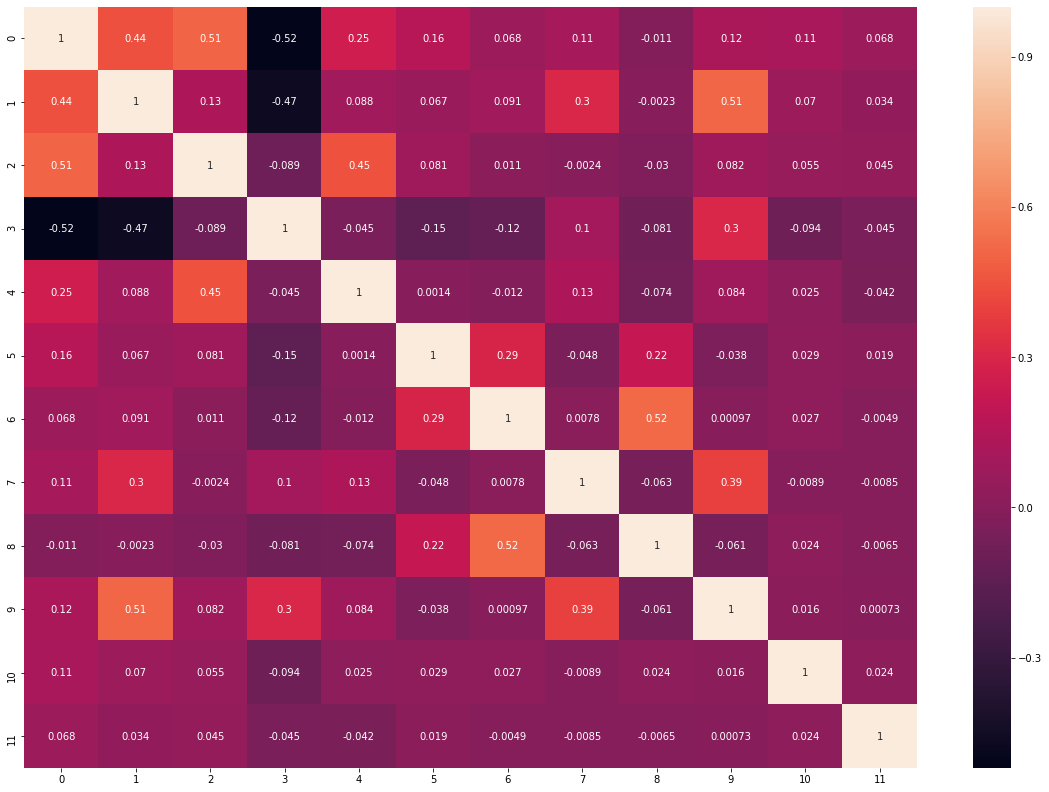

In [693]:
import matplotlib.pyplot as plt
import seaborn as sns

print(data.columns)

# get correlation matrix
corrmatrix = matrix.collect()[0][0].toArray().tolist()

plt.figure(figsize = (20,14))
ax = sns.heatmap(corrmatrix, annot=True) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Looking at the plot, we see anything unexpected. We notice that 'yearOfRegistration' and 'kilometer' have a correlation coefficient of -0.47 which is expected for cars with higher kilometer values will very likely have a smaller year of registration. Similarily, we see that 'yearOfRegistration' and 'kilo_per_year' are correlated with a coefficient of 0.52 which also makes sense as newer cars will likely be driven more when they are newer. Regardless of these correlations, the highest magnitude of correlation that was see is 0.52, which seems to indicate that we do not need to remove features because of high correlation with other features.

In [694]:
data.columns

['price',
 'yearOfRegistration',
 'powerPS',
 'kilometer',
 'gearbox_num',
 'vehicleType_num',
 'model_num',
 'fuelType_num',
 'brand_num',
 'kilo_per_year',
 'days_to_sell',
 'region']

### Principal Component Analysis

Principal Component Analysis or PCA for short, is a very common preprocessing technique in machine learning that involves transforming vectors in our original feature space into a new space where the resulting principal components are very loosely correlated to one another. PCA is especially helpful in regression models, as it helps model stability and allows us to remove variables by simply dropping some of the least significant principal components.

In [695]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

featurecols =  ['yearOfRegistration','powerPS','kilometer','gearbox_num','vehicleType_num','model_num','fuelType_num','brand_num','kilo_per_year','days_to_sell','region']

#Create a new dataframe with one field with entries as 10-dimensional vectors
assembler = VectorAssembler(inputCols = featurecols, outputCol="features")
feature_df = assembler.transform(data).select("price", "features")

feature_df.show()

+-------+--------------------+
|  price|            features|
+-------+--------------------+
|  650.0|[1995.0,102.0,150...|
| 2200.0|[2004.0,109.0,150...|
| 2000.0|[2004.0,105.0,150...|
| 2799.0|[2005.0,140.0,150...|
|17999.0|[2011.0,190.0,700...|
| 7550.0|[2007.0,136.0,150...|
| 1850.0|[2004.0,102.0,150...|
|10400.0|[2009.0,160.0,100...|
| 3699.0|[2002.0,231.0,150...|
|  500.0|[1990.0,118.0,150...|
| 2500.0|[2002.0,193.0,150...|
| 3300.0|[1995.0,113.0,150...|
|18000.0|[2007.0,218.0,200...|
| 3500.0|[2004.0,122.0,150...|
|11900.0|[2002.0,129.0,150...|
| 7999.0|[2007.0,177.0,150...|
| 2100.0|[1998.0,193.0,150...|
|13500.0|[2012.0,109.0,150...|
|39600.0|[2014.0,306.0,300...|
| 1000.0|[1998.0,101.0,150...|
+-------+--------------------+
only showing top 20 rows



In [696]:
pca = PCA(k=9, inputCol="features", outputCol="pca")
model = pca.fit(feature_df)
transformed = model.transform(feature_df)

transformed = transformed.drop("features")

transformed.show()

+-------+--------------------+
|  price|                 pca|
+-------+--------------------+
|  650.0|[150141.548236219...|
| 2200.0|[150297.975354593...|
| 2000.0|[150297.975590730...|
| 2799.0|[150329.259738392...|
|17999.0|[70335.4848256455...|
| 7550.0|[150409.704141529...|
| 1850.0|[150297.975941595...|
|10400.0|[100351.949732278...|
| 3699.0|[150247.500474296...|
|  500.0|[150098.883503623...|
| 2500.0|[150247.505377367...|
| 3300.0|[150141.546042869...|
|18000.0|[20054.4791629166...|
| 3500.0|[150297.975171230...|
|11900.0|[150247.513668057...|
| 7999.0|[150409.704320907...|
| 2100.0|[150177.635648140...|
|13500.0|[150866.812458448...|
|39600.0|[30282.9180553003...|
| 1000.0|[150177.647343135...|
+-------+--------------------+
only showing top 20 rows



Now that we have performed PCA, all we have to do is scale our data.

In [697]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="pca", outputCol="scaled_features", withStd=True, withMean=True)
scaled_df = scaler.fit(transformed).transform(transformed)

scaled_df.show()

Exception ignored in: <function JavaWrapper.__del__ at 0x000002238D909A68>
Traceback (most recent call last):
  File "C:\Users\1019l\Anaconda3\lib\site-packages\pyspark\ml\wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'RegressionEvaluator' object has no attribute '_java_obj'


+-------+--------------------+--------------------+
|  price|                 pca|     scaled_features|
+-------+--------------------+--------------------+
|  650.0|[150141.548236219...|[0.61891010114022...|
| 2200.0|[150297.975354593...|[0.62288941085892...|
| 2000.0|[150297.975590730...|[0.62288941686595...|
| 2799.0|[150329.259738392...|[0.62368524634954...|
|17999.0|[70335.4848256455...|[-1.4112560685239...|
| 7550.0|[150409.704141529...|[0.62573165108129...|
| 1850.0|[150297.975941595...|[0.62288942579151...|
|10400.0|[100351.949732278...|[-0.6476748444651...|
| 3699.0|[150247.500474296...|[0.62160539320390...|
|  500.0|[150098.883503623...|[0.61782476384813...|
| 2500.0|[150247.505377367...|[0.62160551793189...|
| 3300.0|[150141.546042869...|[0.61891004534414...|
|18000.0|[20054.4791629166...|[-2.6903417959830...|
| 3500.0|[150297.975171230...|[0.62288940619441...|
|11900.0|[150247.513668057...|[0.62160572883665...|
| 7999.0|[150409.704320907...|[0.62573165564444...|
| 2100.0|[15

In [698]:
scaled_df = scaled_df.drop('pca')

Now that all of our data is scaled we are ready to train our model. 

# Model

Before we begin training our model, we will have to partition our dataset into a training and test set.

In [699]:
train_data, test_data = scaled_df.withColumnRenamed("price", "target").withColumnRenamed("scaled_features", "features") \
.randomSplit([.8,.2],seed=4710)

print('Train Data Count: {0}\n'.format(train_data.count()))
train_data.show()
print('Test Data Count: {0}\n'.format(test_data.count()))
test_data.show()

Train Data Count: 134736

+------+--------------------+
|target|            features|
+------+--------------------+
| 100.0|[0.61842256712043...|
| 100.0|[0.61842274042243...|
| 100.0|[0.61891004511546...|
| 110.0|[0.61918770628867...|
| 120.0|[0.61891003236583...|
| 130.0|[0.61890959265765...|
| 150.0|[-0.0176595646746...|
| 150.0|[0.61918735865376...|
| 150.0|[0.61949192467953...|
| 150.0|[0.62220301014914...|
| 150.0|[0.62573153093785...|
| 160.0|[0.62020056892195...|
| 180.0|[0.61918769443298...|
| 180.0|[0.62108049139223...|
| 199.0|[0.61949230874896...|
| 200.0|[0.61800905810722...|
| 200.0|[0.61842274264740...|
| 200.0|[0.61891001593869...|
| 200.0|[0.61949185403424...|
| 200.0|[0.61949234978829...|
+------+--------------------+
only showing top 20 rows

Test Data Count: 34034

+------+--------------------+
|target|            features|
+------+--------------------+
| 150.0|[0.61949245716459...|
| 150.0|[0.61982831775472...|
| 150.0|[0.61982833190765...|
| 180.0|[0.6194924144682

Good, now we are ready to train our base models for our ensemble model.

### Linear Regression

In [700]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="target", predictionCol="lr_predict", maxIter=25, regParam=0.3, elasticNetParam=0.8)

linearModel = lr.fit(train_data)

In [701]:
from pyspark.sql.functions import rand

lrpredictions = linearModel.transform(test_data)

lrpredictions.select("lr_predict", "target").orderBy(rand(4710)).limit(5).show()

+------------------+-------+
|        lr_predict| target|
+------------------+-------+
| 7927.131672542593|12500.0|
| 7134.037349520637| 1300.0|
| 9326.994244696445| 7300.0|
|3539.3226373681155| 2300.0|
| 2963.014979096458| 3199.0|
+------------------+-------+



In [702]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="target", predictionCol="lr_predict", metricName="rmse")
rmse = evaluator.evaluate(lrpredictions)
print("RMSE: {0}\n".format(rmse))

RMSE: 6111.850360817967



### Decision Tree

In [703]:
from pyspark.ml.regression import DecisionTreeRegressor

dtr = DecisionTreeRegressor(labelCol="target", predictionCol="dtr_predict")

decisionTreeModel = dtr.fit(train_data)

In [704]:
dtrpredictions = decisionTreeModel.transform(test_data)

dtrpredictions.select("dtr_predict", "target").orderBy(rand(4710)).limit(5).show()

+-----------------+-------+
|      dtr_predict| target|
+-----------------+-------+
|2449.945568285317|12500.0|
|4948.906739166255| 1300.0|
|4948.906739166255| 7300.0|
|2449.945568285317| 2300.0|
|2449.945568285317| 3199.0|
+-----------------+-------+



In [705]:
evaluator = RegressionEvaluator(labelCol="target", predictionCol="dtr_predict", metricName="rmse")
rmse = evaluator.evaluate(dtrpredictions)
print("RMSE: {0}\n".format(rmse))

RMSE: 5673.493658152552



### Random Forest

In [706]:
from pyspark.ml.regression import RandomForestRegressor

rfr = RandomForestRegressor(labelCol="target", predictionCol="rfr_predict")

randomForestmodel = rfr.fit(train_data)

In [707]:
rfrpredictions = randomForestmodel.transform(test_data)

rfrpredictions.select("rfr_predict", "target").orderBy(rand(4710)).limit(5).show()

+-----------------+-------+
|      rfr_predict| target|
+-----------------+-------+
|3499.623512666735|12500.0|
|4093.854060932722| 1300.0|
|4279.148381318414| 7300.0|
|3499.623512666735| 2300.0|
|3164.627858713663| 3199.0|
+-----------------+-------+



In [708]:
evaluator = RegressionEvaluator(labelCol="target", predictionCol="rfr_predict", metricName="rmse")
rmse = evaluator.evaluate(rfrpredictions)
print("RMSE: {0}\n".format(rmse))

RMSE: 5660.510776837747



### Gradient-boosted Tree Regression

In [709]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(labelCol="target", predictionCol="gbt_predict")

GBTModel = gbt.fit(train_data)

In [710]:
gbtpredictions = GBTModel.transform(test_data)

gbtpredictions.select("gbt_predict", "target").orderBy(rand(4710)).limit(5).show()

+------------------+-------+
|       gbt_predict| target|
+------------------+-------+
| 6980.757297384484|12500.0|
| 3847.158092898947| 1300.0|
|5088.2603866954105| 7300.0|
|1870.0302868209349| 2300.0|
| 898.3899688230628| 3199.0|
+------------------+-------+



In [711]:
evaluator = RegressionEvaluator(labelCol="target", predictionCol="gbt_predict", metricName="rmse")
rmse = evaluator.evaluate(gbtpredictions)
print("RMSE: {0}\n".format(rmse))

RMSE: 4864.4646622488945



It seems like our gradient-boosted tree regression algorithm performed the best, thus we will use that as our meta learner.

## Ensemble Model

In [720]:
metaRegressor = GBTRegressor(featuresCol = "features_combined", labelCol="target", predictionCol="meta_predict")

lroutput = linearModel.transform(train_data).select("lr_predict").withColumn("id", monotonically_increasing_id())
dtroutput = decisionTreeModel.transform(train_data).select("dtr_predict").withColumn("id", monotonically_increasing_id())
rfroutput = randomForestmodel.transform(train_data).select("rfr_predict").withColumn("id", monotonically_increasing_id())
gbtoutput = GBTModel.transform(train_data).select("gbt_predict").withColumn("id", monotonically_increasing_id())

combined_output = lroutput.join(dtroutput.join(rfroutput.join(gbtoutput, "id", "outer"), "id", "outer"), "id", "outer").drop("id")

combined_output.show()

assembler = VectorAssembler(inputCols = combined_output.columns, outputCol="features_combined")
combined_output = assembler.transform(combined_output).select("features_combined")

combined_output.show()

+-------------------+------------------+------------------+------------------+
|         lr_predict|       dtr_predict|       rfr_predict|       gbt_predict|
+-------------------+------------------+------------------+------------------+
|  871.6298297752301| 2449.945568285317|3113.3609987930386|1501.0021531601792|
| 15488.783300903755| 5405.160399334442|  9890.69562339402| 5292.145301940059|
| 343.69104995772796| 2449.945568285317|3068.8516465749176|1094.1025647971423|
| 1069.1613092920488| 2449.945568285317|4065.4427245371908|1061.7065263605039|
|  686.4694117554673| 2449.945568285317| 4363.716526684979|3095.1749440592757|
| 1251.1828585174972| 2449.945568285317| 4363.716526684979| 2637.397793621553|
|-1252.7223762667745| 2449.945568285317|3113.3609987930386|1316.8113566781287|
|  5792.552674905766| 4948.906739166255|  6287.32616598586| 4759.445702673936|
|  1806.091517728135| 2449.945568285317|4065.4427245371908|1665.1297270563728|
| 4021.0534024041035| 4948.906739166255| 5227.985860

In [721]:
combined_output = combined_output.withColumn("id", monotonically_increasing_id())

labels = train_data.select("target").withColumn("id", monotonically_increasing_id())

combined_output.show()
labels.show()

+--------------------+---+
|   features_combined| id|
+--------------------+---+
|[871.629829775230...|  0|
|[15488.7833009037...|  1|
|[343.691049957727...|  2|
|[1069.16130929204...|  3|
|[686.469411755467...|  4|
|[1251.18285851749...|  5|
|[-1252.7223762667...|  6|
|[5792.55267490576...|  7|
|[1806.09151772813...|  8|
|[4021.05340240410...|  9|
|[-1187.8833288783...| 10|
|[2721.62392662334...| 11|
|[3157.25345443922...| 12|
|[909.066112481655...| 13|
|[5147.78809320990...| 14|
|[2058.86951581913...| 15|
|[4956.45778753441...| 16|
|[2595.59934628646...| 17|
|[2080.37670403748...| 18|
|[10002.7512349648...| 19|
+--------------------+---+
only showing top 20 rows

+------+---+
|target| id|
+------+---+
| 100.0|  0|
| 100.0|  1|
| 100.0|  2|
| 110.0|  3|
| 120.0|  4|
| 130.0|  5|
| 150.0|  6|
| 150.0|  7|
| 150.0|  8|
| 150.0|  9|
| 150.0| 10|
| 160.0| 11|
| 180.0| 12|
| 180.0| 13|
| 199.0| 14|
| 200.0| 15|
| 200.0| 16|
| 200.0| 17|
| 200.0| 18|
| 200.0| 19|
+------+---+
only showing t

In [722]:
new_out = labels.join(combined_output, labels.id==combined_output.id).drop("id")

new_out.show()

+------+--------------------+
|target|   features_combined|
+------+--------------------+
| 100.0|[871.629829775230...|
| 100.0|[15488.7833009037...|
| 100.0|[343.691049957727...|
| 110.0|[1069.16130929204...|
| 120.0|[686.469411755467...|
| 130.0|[1251.18285851749...|
| 150.0|[-1252.7223762667...|
| 150.0|[5792.55267490576...|
| 150.0|[1806.09151772813...|
| 150.0|[4021.05340240410...|
| 150.0|[-1187.8833288783...|
| 160.0|[2721.62392662334...|
| 180.0|[3157.25345443922...|
| 180.0|[909.066112481655...|
| 199.0|[5147.78809320990...|
| 200.0|[2058.86951581913...|
| 200.0|[4956.45778753441...|
| 200.0|[2595.59934628646...|
| 200.0|[2080.37670403748...|
| 200.0|[10002.7512349648...|
+------+--------------------+
only showing top 20 rows



In [725]:
metamodel = metaRegressor.fit(new_out)

In [726]:
train_data.orderBy(rand(4710)).limit(5).show()

+-------+--------------------+
| target|            features|
+-------+--------------------+
|22500.0|[-0.0108528689989...|
| 3760.0|[0.62461965091111...|
| 2100.0|[0.61865592495433...|
| 7499.0|[-0.0136803493034...|
|14000.0|[-0.0143436937220...|
+-------+--------------------+



In [727]:
lroutput_test = linearModel.transform(test_data).select("lr_predict").withColumn("id", monotonically_increasing_id())
dtroutput_test = decisionTreeModel.transform(test_data).select("dtr_predict").withColumn("id", monotonically_increasing_id())
rfroutput_test = randomForestmodel.transform(test_data).select("rfr_predict").withColumn("id", monotonically_increasing_id())
gbtoutput_test = GBTModel.transform(test_data).select("gbt_predict").withColumn("id", monotonically_increasing_id())

combined_output_test = lroutput_test.join(dtroutput_test.join(rfroutput_test.join(gbtoutput_test, "id", "outer"), "id", "outer"), "id", "outer").drop("id")

combined_output.show()

assembler = VectorAssembler(inputCols = combined_output_test.columns, outputCol="features_combined")
combined_output_test = assembler.transform(combined_output_test).select("features_combined")

combined_output_test = combined_output_test.withColumn("id", monotonically_increasing_id())

test_labels = test_data.select("target").withColumn("id", monotonically_increasing_id())

combined_output.show()
labels.show()

+--------------------+---+
|   features_combined| id|
+--------------------+---+
|[871.629829775230...|  0|
|[15488.7833009037...|  1|
|[343.691049957727...|  2|
|[1069.16130929204...|  3|
|[686.469411755467...|  4|
|[1251.18285851749...|  5|
|[-1252.7223762667...|  6|
|[5792.55267490576...|  7|
|[1806.09151772813...|  8|
|[4021.05340240410...|  9|
|[-1187.8833288783...| 10|
|[2721.62392662334...| 11|
|[3157.25345443922...| 12|
|[909.066112481655...| 13|
|[5147.78809320990...| 14|
|[2058.86951581913...| 15|
|[4956.45778753441...| 16|
|[2595.59934628646...| 17|
|[2080.37670403748...| 18|
|[10002.7512349648...| 19|
+--------------------+---+
only showing top 20 rows

+--------------------+---+
|   features_combined| id|
+--------------------+---+
|[871.629829775230...|  0|
|[15488.7833009037...|  1|
|[343.691049957727...|  2|
|[1069.16130929204...|  3|
|[686.469411755467...|  4|
|[1251.18285851749...|  5|
|[-1252.7223762667...|  6|
|[5792.55267490576...|  7|
|[1806.09151772813...|  8|
|[

In [731]:
new_test_out = test_labels.join(combined_output_test, test_labels.id==combined_output_test.id).drop("id")

new_test_out.show()

+------+--------------------+
|target|   features_combined|
+------+--------------------+
| 150.0|[-222.92102682914...|
| 150.0|[242.509846173199...|
| 150.0|[1280.63203151569...|
| 180.0|[6100.32733403220...|
| 199.0|[10633.5605553280...|
| 200.0|[7289.59871226432...|
| 200.0|[22043.7505668494...|
| 222.0|[16919.0809179300...|
| 250.0|[18139.9063967096...|
| 250.0|[14569.4462004053...|
| 250.0|[15801.1352302193...|
| 300.0|[17461.2708686231...|
| 300.0|[19886.0027898346...|
| 300.0|[16151.4881963758...|
| 300.0|[5226.93628272197...|
| 300.0|[2910.27989586245...|
| 350.0|[3187.85755231661...|
| 350.0|[6131.12882405147...|
| 350.0|[-1624.0835441947...|
| 370.0|[676.870058186533...|
+------+--------------------+
only showing top 20 rows



In [732]:
metapredictions = metamodel.transform(new_test_out)

metapredictions.select("meta_predict", "target").orderBy(rand(4710)).limit(5).show()

+-----------------+------+
|     meta_predict|target|
+-----------------+------+
|635.7572660966929| 400.0|
|683.6771192052952| 600.0|
|694.8457752991549| 300.0|
|659.0234957442658| 700.0|
|636.9397397295203| 890.0|
+-----------------+------+



In [ ]:
evaluator = RegressionEvaluator(labelCol="target", predictionCol="meta_predict", metricName="rmse")
rmse = evaluator.evaluate(metapredictions)
print("RMSE: {0}\n".format(rmse))